<a href="https://colab.research.google.com/github/gulabpatel/LLMs/blob/main/RAG/04_RAG_re_ranking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

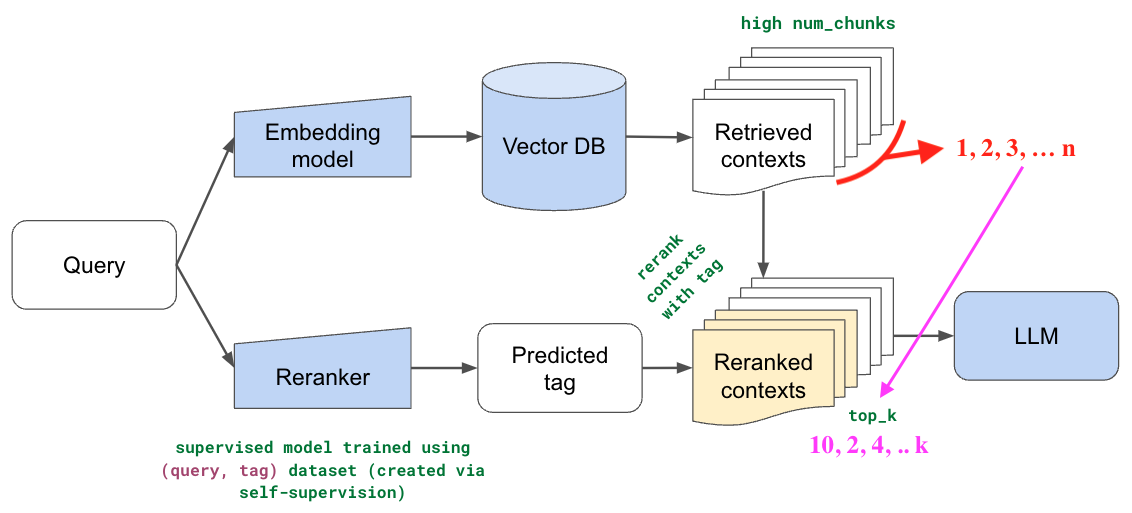

# Problem Statement:


In a typical RAG pipeline, LLM Context window is limited so for a hypothetical 10000 pages document, we need to chunk the document. For any incoming user query, we need to fetch `Top-N` related chunks and because neither our Embedding are 100% accurate nor search algo is perfect, it could give us unrelated results too. This is a flaw in RAG pipeline. How can you deal with it? If you fetch Top-1 and the context is different then it's a sure bad answer. On the other hand, if you fetch more chunks and pass to LLM, it'll get confused and with higher number, it'll go out of context.

# What's the remedy?

Out of all the methods available, Re-ranking is the simplest. Idea is pretty simple.


1. You assume that Embedding + Search algo are not 100% precise so you use Recall to your advantage and get similar high `N` (say 25) number of related chunks from corpus.

2. Second step is to use a powerful model to increase the Precision. You re-rank above `N` queries again so that you can change the relative ordering and now select Top `K` queries (say 3) to pass as a context where `K` < `N` thus increasing the Precision.


# Why can't you use the bigger model in the first place?
Would your search results be better if you were searching in 100 vs 100000 documents? Yes, so no matter how big of a model you use, you'll always have some irrelevent results because of the huge domain.


Smaller model with efficient searching algo does the work of searching in a bigger domain to get more number of elements while the larger model is precise and because it just works on `K`, there is a bit more overhead but improved relevancy.


In [3]:
!pip install -U lancedb transformers datasets FlagEmbedding unstructured langchain -qq

# NOTE: If there is an import error, restart and run the notebook again

In [4]:
from FlagEmbedding import LLMEmbedder, FlagReranker # Al document present here https://github.com/FlagOpen/FlagEmbedding/tree/master
import os
import lancedb
import re
import pandas as pd
import random
from datasets import load_dataset
import torch
import gc
import lance
from lancedb.embeddings import with_embeddings


task = "qa" # Encode for a specific task (qa, icl, chat, lrlm, tool, convsearch)
embed_model = LLMEmbedder('BAAI/llm-embedder', use_fp16=False) # Load model (automatically use GPUs)

reranker_model = FlagReranker('BAAI/bge-reranker-base', use_fp16=True) # use_fp16 speeds up computation with a slight performance degradation

# For basic splitting
# basic_text_splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=64,) # 512 is the default Embedding model max_len

# For Advanced Usage: https://python.langchain.com/docs/modules/data_connection/document_transformers/text_splitters/split_by_token
# embedder_tokenizer = AutoTokenizer.from_pretrained("BAAI/llm-embedder") # Advanced Tokenizer Splitter Strategy
# advanced_text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(embedder_tokenizer, chunk_size=512, chunk_overlap=0)

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

# Load `Chunks` of data from [BeIR Dataset](https://huggingface.co/datasets/BeIR/scidocs)

Note: This is a dataset built specially for retrieval tasks to see how good your search is working

In [5]:
queries = load_dataset("BeIR/scidocs", "queries")["queries"].to_pandas()
docs = load_dataset('BeIR/scidocs', 'corpus')["corpus"].to_pandas().dropna(subset = "text").sample(10000) # just random samples for faster embed demo
docs.sample(3)

Generating queries split: 0 examples [00:00, ? examples/s]

Generating corpus split: 0 examples [00:00, ? examples/s]

,_id,title,text
18719,127a818c2ba1bbafbabc62d4163b0dd98364f64a,NFC Antenna With Nonuniform Meandering Line an...,This paper proposes a near-field communication...
23594,0fb45e704ef3ca1f9c70e7be3fb93b53714ed8b5,Head Pose and Expression Transfer Using Facial...,We propose a method to transfer both head pose...
12957,18ad2478014dd61d38e8197ff7060e9997e7a989,Evolving neural networks to play checkers with...,An experiment was conducted where neural netwo...


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('_id').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('title').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('text').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['title'].value_counts()
    for x_label, grp in _df_5.groupby('_id')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('_id')
_ = plt.ylabel('title')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['text'].value_counts()
    for x_label, grp in _df_6.groupby('title')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('title')
_ = plt.ylabel('text')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_7['_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_7, x='index', y='_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_8['title'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_8, x='index', y='title', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['text'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='index', y='text', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

# Get embedding using [`LLM embedder`](https://github.com/FlagOpen/FlagEmbedding/tree/master/FlagEmbedding/llm_embedder) and create Database using [`LanceDB`](https://github.com/lancedb/lancedb)

In [6]:
def embed_documents(batch):
    """
    Function to embed the whole text data
    """
    return embed_model.encode_keys(batch, task=task) # Encode data or 'keys'


db = lancedb.connect("./db") # Connect Local DB
if "doc_embed" in db.table_names():
  table = db.open_table("doc_embed") # Open Table
else:
  # Use the train text chunk data to save embed in the DB
  data = with_embeddings(embed_documents, docs, column = 'text',show_progress = True, batch_size = 128)
  table = db.create_table("doc_embed", data=data) # create Table

  0%|          | 0/79 [00:00<?, ?it/s]

# Search from a random Text

In [8]:
def search(query, top_k = 10):
  """
  Search a query from the table
  """
  query_vector = embed_model.encode_queries(query, task=task) # Encode the QUERY (it is done differently than the 'key')
  search_results = table.search(query_vector).limit(top_k)
  return search_results


query = random.choice(queries["text"])
print("QUERY:-> ", query)

# get top_k search results
search_results = search("what is mitochondria?", top_k = 10).to_pandas().dropna(subset = "text").reset_index(drop = True)

search_results

QUERY:->  Analyzing Thermal and Visual Clues of Deception for a Non-Contact Deception Detection Approach


,_id,title,text,vector,_distance
0,cdefa98415b1f072989214b62e51073c82304e33,The role of autophagy in cancer development an...,Autophagy is a process in which subcellular me...,"[-0.012342801, 0.01908416, -0.007264477, -0.00...",0.324180
1,44e1725621ec51b8bc37f68e89151295570bdd0b,Induced pluripotent stem cell-based modeling o...,The advent of cell reprogramming has enabled t...,"[-0.02205047, -0.025585497, -0.04828727, 0.010...",0.358758
2,587ad4f178340d7def5437fe5ba0ab0041a53c4b,Ocular symptom detection using smartphones,"It is often said that ""the eyes are the window...","[0.012119503, 0.045184053, 0.007815625, -0.019...",0.361441
3,55f0f716a355adc7e29593bf650590b1a5a552b5,Cell biology of protein misfolding: The exampl...,The salutary intersection of fundamental cell ...,"[-0.03869332, -0.0055972184, -0.041978512, -0....",0.369358
4,c65945c08b7fd77ffd2c53369e8928699c3993e7,Comparing Alzheimer’s and Parkinson’s diseases...,Recent advances in large datasets analysis off...,"[-0.004613002, -0.0044279, -0.013920471, 0.002...",0.369777
5,1af2e075903a3cc5ad5a192921a0b4fb67645dc1,Mathematical models of cancer metabolism.,"Metabolism is essential for life, and its alte...","[-0.0037386413, 0.011562059, -0.022478998, 0.0...",0.370502
6,488257dcbc7bcb56836f10a410e69c2c283989e5,mTOR Signaling in Growth Control and Disease,The mechanistic target of rapamycin (mTOR) sig...,"[0.00065670727, 0.005348704, -0.0010087418, -0...",0.376821
7,65f415c6d88aca139867702fc64aa179781b8e65,PID: the Pathway Interaction Database,"The Pathway Interaction Database (PID, http://...","[-0.007852335, 0.014019221, -0.02678918, -0.00...",0.378376
8,55877f7c574b4686c98e70b96971722c1593ba9f,Calorie restriction extends Saccharomyces cere...,Calorie restriction (CR) extends lifespan in a...,"[-0.028346231, 0.02385237, -0.024740309, 0.006...",0.381003
9,d25ceed5ff16bff36e0c91549e51501e6ca4ddb0,CO2 bio-mitigation using microalgae,Microalgae are a group of unicellular or simpl...,"[0.034966998, 0.028465202, -0.015458229, 0.022...",0.381480


# Rerank Search Results using Reranker from [`BGE Reranker`](https://github.com/FlagOpen/FlagEmbedding/tree/master/FlagEmbedding/reranker)

Pass all the results to a stronger model to give them the similarity ranking

In [12]:
search_results.index+1

RangeIndex(start=1, stop=11, step=1)

In [13]:
def rerank(query, search_results):
  search_results["old_similarity_rank"] = search_results.index+1 # Old ranks

  torch.cuda.empty_cache()
  gc.collect()

  search_results["new_scores"] = reranker_model.compute_score([[query,chunk] for chunk in search_results["text"]]) # Re compute ranks
  return search_results.sort_values(by = "new_scores", ascending = False).reset_index(drop = True)

print("QUERY:-> ", query)

rerank(query, search_results)

QUERY:->  Analyzing Thermal and Visual Clues of Deception for a Non-Contact Deception Detection Approach


,_id,title,text,vector,_distance,old_similarity_rank,new_scores
0,c65945c08b7fd77ffd2c53369e8928699c3993e7,Comparing Alzheimer’s and Parkinson’s diseases...,Recent advances in large datasets analysis off...,"[-0.004613002, -0.0044279, -0.013920471, 0.002...",0.369777,5,-6.140625
1,44e1725621ec51b8bc37f68e89151295570bdd0b,Induced pluripotent stem cell-based modeling o...,The advent of cell reprogramming has enabled t...,"[-0.02205047, -0.025585497, -0.04828727, 0.010...",0.358758,2,-6.703125
2,cdefa98415b1f072989214b62e51073c82304e33,The role of autophagy in cancer development an...,Autophagy is a process in which subcellular me...,"[-0.012342801, 0.01908416, -0.007264477, -0.00...",0.324180,1,-7.097656
3,1af2e075903a3cc5ad5a192921a0b4fb67645dc1,Mathematical models of cancer metabolism.,"Metabolism is essential for life, and its alte...","[-0.0037386413, 0.011562059, -0.022478998, 0.0...",0.370502,6,-7.234375
4,488257dcbc7bcb56836f10a410e69c2c283989e5,mTOR Signaling in Growth Control and Disease,The mechanistic target of rapamycin (mTOR) sig...,"[0.00065670727, 0.005348704, -0.0010087418, -0...",0.376821,7,-7.671875
5,587ad4f178340d7def5437fe5ba0ab0041a53c4b,Ocular symptom detection using smartphones,"It is often said that ""the eyes are the window...","[0.012119503, 0.045184053, 0.007815625, -0.019...",0.361441,3,-7.703125
6,55f0f716a355adc7e29593bf650590b1a5a552b5,Cell biology of protein misfolding: The exampl...,The salutary intersection of fundamental cell ...,"[-0.03869332, -0.0055972184, -0.041978512, -0....",0.369358,4,-7.781250
7,55877f7c574b4686c98e70b96971722c1593ba9f,Calorie restriction extends Saccharomyces cere...,Calorie restriction (CR) extends lifespan in a...,"[-0.028346231, 0.02385237, -0.024740309, 0.006...",0.381003,9,-8.539062
8,65f415c6d88aca139867702fc64aa179781b8e65,PID: the Pathway Interaction Database,"The Pathway Interaction Database (PID, http://...","[-0.007852335, 0.014019221, -0.02678918, -0.00...",0.378376,8,-8.906250
9,d25ceed5ff16bff36e0c91549e51501e6ca4ddb0,CO2 bio-mitigation using microalgae,Microalgae are a group of unicellular or simpl...,"[0.034966998, 0.028465202, -0.015458229, 0.022...",0.381480,10,-10.156250
